# Abstract

The problem chosen is from Kaggle and its a **Multi class image classification problem**. 

The Dataset for this problem has been taken from kaggle - [Intel Image Classification
Image Scene Classification of Multiclass](https://www.kaggle.com/puneet6060/intel-image-classification)

This Data contains around **25000** **images** of size 150x150 distributed under 6 categories.



```

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

```


The Train, Test and Prediction data is separated in each zip files. There are around **14000** images in **Train**, **3000** in **Test** and **7000** in **Prediction**.

For this problem the Convolution Neural Network has been built from scratch using Pytorch 🔦

**Acknowledgement**

This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

### 1.1 Importing necessary libraries

In [1]:
import os
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# from resources.plotcm import plot_confusion_matrix
import pandas as pd
import glob
from PIL import Image
from io import open
from tqdm import tqdm
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
!pip install tensorflow-plot

  Created wheel for tensorflow-plot: filename=tensorflow_plot-0.3.2-py3-none-any.whl size=25943 sha256=09be44634b638da7c7ac751ddbc107726f4965b66ecf4464c8a19590047037c7
  Stored in directory: /root/.cache/pip/wheels/ae/34/9d/419e91d3b091398f462d204cb136a697c108ec29e30097c4e7
  Created wheel for biwrap: filename=biwrap-0.1.6-py3-none-any.whl size=3384 sha256=70f005b8f088157eaff8b16376aa044948fa1c5aac56b6cae02782645506ad6f
  Stored in directory: /root/.cache/pip/wheels/37/b0/84/a21457c4500e9c748adefa5cf7e2263a288437716955a1efe7
Successfully built tensorflow-plot biwrap


In [3]:
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


### 1.2 Loading the dataset source 📁

Lets mount the Google Drive first, this has the dataset in Zip format which we will need to extract using a script.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "/content/drive/My Drive/Intel-image-classification-dataset.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7539.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7551.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7560.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7565.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7578.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7581.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7586.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7647.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7652.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/7654.jpg  
  inflating: /content/Intel-image-classification-dataset/seg_train/mountain/766

We can get a glance at the Colab GPU in use and Torch support with the following snippets of code:

In [6]:
!nvidia-smi

Mon Dec  6 23:35:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1.3 Dataset: Pre-Processing Images 📸

Reference - [Pytorch - TorchVision Transforms](https://pytorch.org/vision/stable/transforms.html)

In order to get a better performing model we will employ standard image pre-processing techniques such as - 

 

*   Resize the Image ✅
*   Use Random Horizontal Flip ✅
*   Use ToTensor to convert image/numpy nd array to torch float tensor ✅
*   Use Normalize function in Pytorch transforms(Image Standardization) - Normalize each channel of Input Tensor ✅



In [8]:
# Image Pre-processing/Augmentation using Pytorch inbuilt transforms
# Normalize -> 2x3 matrix -> col is RGB channel and row is mean, deviation
# Normalize - Convert 0-1 to  [-1,1], mean and std for 3 channel is 0.5 -> formula = (x-mean)/std
transformer = transforms.Compose([
                                  transforms.Resize((150,150)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(), # 0-255 to 0-1 , numpy to tensor
                                  transforms.Normalize([0.5,0.5,0.5],
                                                       [0.5,0.5,0.5]) 
]) 

### 1.4 Loading the Dataset using **DataLoader** ⚒

In dealing with CNN problems and datasets, pytorch dataloader helps us to load the data in batches so that the GPU is not overloaded.

Reference - [torchvision ImageFolder](https://pytorch.org/vision/0.8/datasets.html#imagefolder)

In [9]:
# Paths for train and test
train_path = '/content/Intel-image-classification-dataset/seg_train'
test_path = '/content/Intel-image-classification-dataset/seg_test'
#Dataloader
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformer),
    batch_size=256, shuffle = True
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformer),
    batch_size=256, shuffle = True
)

In [10]:
initial_count = 0
for path in pathlib.Path(".").iterdir():
    if path.is_file():
        initial_count += 1

print(initial_count)

len(os.listdir(train_path))

0


6

In [11]:
#categories
root = pathlib.Path(train_path)
print(root.iterdir())
classes = sorted(j.name.split('/')[-1] for j in root.iterdir())
print(classes)

<generator object Path.iterdir at 0x7f871d7afe50>
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### 1.5 Peek at the Dataset and Visualize 📊

In [12]:
dictData_train = {}
dictData_test = {}
for i in classes:
  if i not in dictData_train:
    dictData_train[i] = len(os.listdir(train_path+'/'+i))
  else:
    dictData_train[i]+=1

for i in classes:
  if i not in dictData_test:
    dictData_test[i] = len(os.listdir(test_path+'/'+i))
  else:
    dictData_test[i]+=1

print(dictData_train)
print(dictData_test)

{'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}
{'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


<BarContainer object of 6 artists>

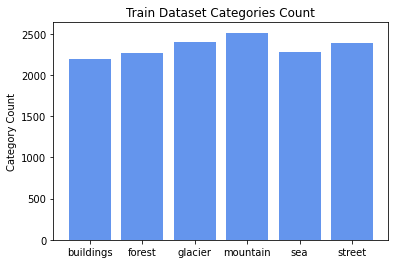

In [13]:
keys = dictData_train.keys()
values = dictData_train.values()
plt.title('Train Dataset Categories Count')
plt.ylabel('Category Count')
plt.bar(keys, values, color='cornflowerblue')

<BarContainer object of 6 artists>

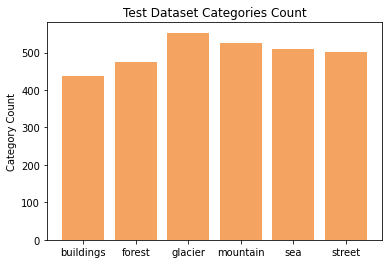

In [14]:
keys = dictData_test.keys()
values = dictData_test.values()
plt.title('Test Dataset Categories Count')
plt.ylabel('Category Count')
plt.bar(keys, values, color = 'sandybrown')

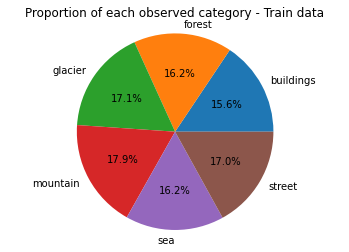

In [15]:
plt.pie(dictData_train.values(),
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=dictData_train.keys(),
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category - Train data')
plt.show()

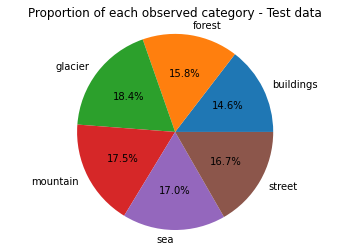

In [16]:
plt.pie(dictData_test.values(),
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=dictData_test.keys(),
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category - Test data')
plt.show()

### 2. Create Convolution Neural Network(CNN) using different layers ⚙

In [17]:
#CNN network
class ConvNet(nn.Module):
  def __init__(self, num_classes=6):
    super(ConvNet,self).__init__()

    # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
    # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,12,150,150)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    #Shape -> (256,12,150,150)
    self.relu1 = nn.ReLU()
    #Shape -> (256,12,150,150)
    self.pool = nn.MaxPool2d(kernel_size=2)
    # Reduce the image size by factor of 2
    #Shape -> (256,12, 75,75)


    # 2nd Layer

    
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,12,75,75)
    self.relu2 = nn.ReLU()
    #Shape -> (256,20,75,75)

    
    # 3rd Layer

    
    self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,32,75,75)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    #Shape -> (256,32,75,75)
    self.relu3 = nn.ReLU()
    #Shape -> (256,32,75,75) 

    self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)

# Feed forward function
  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn2(output)
    output = self.relu3(output)

    # the output will be in matric form of shape (256,32,75,75)
    # in order to feed it to fully connected layer output needs to be reshaped

    output = output.view(-1,32*75*75)
    output = self.fullyConnected(output)

    return output


### 3.1 Training the CNN with the dataset & model saving 📩

Training the CNN with the dataset and saving the best model based on best test accuracy

In [18]:
model = ConvNet(num_classes=6).to(device)

In [19]:
# Get model summary 
# Reference - https://stackoverflow.com/questions/42480111/model-summary-in-pytorch
summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
              ReLU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           5,792
       BatchNorm2d-8           [-1, 32, 75, 75]              64
              ReLU-9           [-1, 32, 75, 75]               0
           Linear-10                    [-1, 6]       1,080,006
Total params: 1,088,402
Trainable params: 1,088,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 12.53
Params size (MB): 4.15
Estima

In [20]:
#optimizer and loss function

'''
Things to try:
•Changing the batch size
•Changing the weight decay parameter
•Reduce the size of the training set (+ weight decay)
•Changing the learning rate

'''


# weight decay is L2 regularization
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# Types of loss fns for multi class image classification
# Reference - https://neptune.ai/blog/pytorch-loss-functions
loss_function = nn.CrossEntropyLoss()

In [21]:
num_epochs = 10

In [22]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [23]:
print(train_count,test_count)

14034 3000


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def createConfusionMatrix(loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = model(Variable(inputs.cuda()))  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(12, 7))    
    return sn.heatmap(df_cm, annot=True).get_figure()

In [ ]:
#Model training and saving best model
# Reference - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

best_accuracy=0.0
train_acc_arr = []
test_acc_arr = []
train_loss_arr = []
writer = SummaryWriter('runs/Image-classification')
tb = SummaryWriter('runs/Train_Test_acc_loss')
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    loop = tqdm(enumerate(train_loader), total = len(train_loader), leave = False)
    for i, (images,labels) in loop:
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        loss=loss_function(outputs,labels)
        #backpropogation
        loss.backward()
        # Update weights
        optimizer.step()
        
        # Multiply loss with image size
        train_loss+= loss.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        if i % 256 == 999:    # every 1000 mini-batches...           
            steps = epoch * len(train_loader) + i # calculate steps 
            batch = i*batch_size # calculate batch 
            # print("Training loss {:.3} Accuracy {:.3} Steps: {}".format(running_loss / batch, accuracy/batch, steps))
            
            # Save accuracy and loss to Tensorboard
            tb.add_scalar('Training loss by steps', running_loss / train_count, steps)
            tb.add_scalar('Training accuracy by steps', accuracy / train_count, steps)

            tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
            tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
            tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
            tb.add_histogram("conv2.weight", model.conv2.weight, epoch)
            tb.add_histogram("conv3.bias", model.conv3.bias, epoch)
            tb.add_histogram("conv3.weight", model.conv3.weight, epoch)
            tb.close()
            tb.flush()
    # Save confusion matrix to Tensorboard
    writer.add_figure("Confusion matrix - Training Data", createConfusionMatrix(train_loader), epoch)
    writer.close()
    writer.flush()
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        if i % 256 == 999:    # every 1000 mini-batches...           
            steps = epoch * len(test_loader) + i # calculate steps 
            batch = i*batch_size # calculate batch 
            # print("Training loss {:.3} Accuracy {:.3} Steps: {}".format(running_loss / batch, accuracy/batch, steps))
            
            # Save accuracy and loss to Tensorboard
            tb.add_scalar('Test loss by steps', running_loss / test_count, steps)
            tb.add_scalar('Test accuracy by steps', accuracy / test_count, steps)
            tb.close()
            tb.flush()
    # Save confusion matrix to Tensorboard
    writer.add_figure("Confusion matrix - Test Data", createConfusionMatrix(test_loader), epoch)
    writer.close()
    writer.flush()
    test_accuracy=test_accuracy/test_count
    
    train_acc_arr.append(train_accuracy)
    test_acc_arr.append(test_accuracy)
    train_loss_arr.append(train_loss)
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    # loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
    # loop.set_postfix(loss = train_loss.item(), acc = train_accuracy.item())
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    

Epoch: 0 Train Loss: tensor(8.1773) Train Accuracy: 0.5392617927889412 Test Accuracy: 0.5806666666666667


Epoch: 1 Train Loss: tensor(1.4541) Train Accuracy: 0.7130540116859057 Test Accuracy: 0.6833333333333333


Epoch: 2 Train Loss: tensor(1.0462) Train Accuracy: 0.7751175716118 Test Accuracy: 0.7253333333333334


Epoch: 3 Train Loss: tensor(0.6101) Train Accuracy: 0.8469431380932022 Test Accuracy: 0.713


Epoch: 4 Train Loss: tensor(0.4533) Train Accuracy: 0.8780105458173009 Test Accuracy: 0.7393333333333333


### 3.2 Plotting model accuracies and losses

In [ ]:
#plot train vs test accuracy

plt.plot(train_acc_arr,'-o')
for i in range(1,10, 2):
  plt.text(i,train_acc_arr[i], str(round(train_acc_arr[i],4)))
plt.plot(test_acc_arr,'-o')
for i in range(1,10, 2):
  plt.text(i,test_acc_arr[i], str(round(test_acc_arr[i],4)))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')

plt.show()

In [ ]:
#plot losses

plt.plot(train_loss_arr,'-o')
for i in range(0,10):
  plt.text(i,train_loss_arr[i], str(round(train_loss_arr[i].item(), 3)))
# plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train'])
plt.title('Train Loss')

plt.show()

### 4.1 Model Inference 🔎

In [ ]:
pred_path = '/content/Intel-image-classification-dataset/seg_pred'

In [ ]:
checkpoint = torch.load('best_checkpoint.model')
model = ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()

In [ ]:
# We call transform again but this time npt have horizontal flip
# As we want to predict on original image
transformer = transforms.Compose([
                                  transforms.Resize((150,150)),
                                  transforms.ToTensor(), # 0-255 to 0-1 , numpy to tensor
                                  transforms.Normalize([0.5,0.5,0.5],
                                                       [0.5,0.5,0.5]) 
]) 

In [ ]:
# prediction function

def prediction(img_path, transformer):
  image = Image.open(img_path)
  image_tensor = transformer(image).float()
  # since pytorch considers images in batches, we add another batch dimention
  image_tensor = image_tensor.unsqueeze_(0)

  if torch.cuda.is_available():
    image_tensor.cuda()

  input = Variable(image_tensor)
  # array of probabilities in output for each category
  output = model(input)
  # use argmax to get the category with max probability
  index = output.data.numpy().argmax()
  pred = classes[index]

  return pred



In [ ]:
images_path = glob.glob(pred_path+'/*.jpg')

In [ ]:
pred_dict = {}
for i in images_path:
  pred_dict[i[i.rfind('/')+1:]]=prediction(i, transformer)

In [ ]:
print(pred_dict)

In [ ]:
tb = SummaryWriter()
model = ConvNet(num_classes=6)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
tb.add_image("images", grid)
tb.add_graph(model, images)
tb.close()

In [ ]:
# !tensorboard --logdir runs
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

### 4.2 Error Analysis
Understanding on which kind of images the classifier has trouble